# Bayesian inference

Bayesian inference is a way to estimate parameters from your data using probability to account for uncertainty in these parameters.  These parameters could be the mean and variance of a Gaussian distribution fit to your dataset or they could be the intercept and slopes of a linear regression model.

There are [many](https://www.datascience.com/blog/introduction-to-bayesian-inference-learn-data-science-tutorials) [interesting](https://link.springer.com/article/10.3758/s13423-017-1262-3) [introductions](https://www.youtube.com/watch?v=0LQmZXCWMFI) to the [theory](http://www.inference.org.uk/itila/) behind Bayesian inference. In this notebook we look at a practical example of how Bayesian inference can be used in oceanography.  In particular, we'll try to characterise the variability in a dataset by fitting Bayesian models.  Subsequent workbooks will look at other problems such as making forecasts of time series.

# Dataset

For this notebook, we use a central dataset in modern oceanography - the estimated Meridional Overturning Circulation in the Atlantic Ocean at 40N.  Our aim is to understand the variability in this time series by fitting statistical models to it.  Data from the RAPID-WATCH MOC monitoring project are funded by the Natural Environment Research Council and are freely available from [the RAPID website](www.rapid.ac.uk/rapidmoc).

Thanks RAPID people for gathering the data and making it so easy to download!

# Software

The analysis will be carried out in python with the Bayesian inference carried out using the [PyMC3](http://docs.pymc.io/) package.  We also use the [xarray](http://xarray.pydata.org/en/stable/) package for easy handling of NetCDF files, [pandas](http://pandas.pydata.org/) to make time series operations easier.  Thanks to all those who contributed to developing the open source packages used below.

All the necessary imports are set out in the cell below.  These packages can all be installed using 'conda install package_name'.  This notebook uses python 3.6.1.

In [24]:
import numpy as np
import pandas as pd
import xarray as xr
import pymc3 as pm
import theano
from scipy import signal

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Load and inspect the dataset

First, we load and inspect the dataset. I've saved it in a sub-directory called 'data', you'll need to add your own path to the data here if you are doing this interactively.  Loading the data is made very easy by the xarray package.

In [25]:
ds = xr.open_dataset('data/moc_transports.nc')
ds

<xarray.Dataset>
Dimensions:       (time: 8419)
Coordinates:
  * time          (time) datetime64[ns] 2004-04-02 2004-04-02T12:00:00 ...
Data variables:
    t_therm10     (time) float64 -17.71 -17.47 -17.23 -17.02 -16.83 -16.68 ...
    t_aiw10       (time) float64 0.8188 0.828 0.8364 0.8424 0.8449 0.843 ...
    t_ud10        (time) float64 -7.654 -8.189 -8.696 -9.154 -9.549 -9.869 ...
    t_ld10        (time) float64 -3.4 -3.388 -3.368 -3.343 -3.316 -3.293 ...
    t_bw10        (time) float64 1.381 1.406 1.43 1.453 1.472 1.486 1.493 ...
    t_gs10        (time) float64 27.56 27.89 28.19 28.44 28.64 28.77 28.84 ...
    t_ek10        (time) float64 -1.006 -1.091 -1.174 -1.243 -1.282 -1.279 ...
    t_umo10       (time) float64 -16.89 -16.64 -16.39 -16.16 -15.96 -15.81 ...
    moc_mar_hc10  (time) float64 9.673 10.18 10.65 11.06 11.42 11.71 11.93 ...
Attributes:
    Title:                         RAPID MOC timeseries
    Institution:                   National Oceanography Centre,UK
    Web

The dataset is a daily time series that comes with the total MOC (mon_mar_hc10) along with all the components that go into calculating the MOC (the variables beginning 't').  The units are in Sverdrups (= $10^{6}$ m$^{3}$ s$^{-1}$).

For clarity, we will extract the time variable and the MOC time series into a Pandas dataframe.

In [33]:
df = pd.DataFrame(data = ds.moc_mar_hc10.values, index = ds.time.values, columns=['moc'])
df.head()

,moc
2004-04-02 00:00:00,9.672908
2004-04-02 12:00:00,10.178232
2004-04-03 00:00:00,10.646517
2004-04-03 12:00:00,11.062938
2004-04-04 00:00:00,11.417306


Before inspecting the moc data we define the following function for time series plotting.

In [27]:
def time_plot(time, y, axkwargs = None, *args, **kwargs):
    """Function for time series plotting.
    
    t is the 1D time-axis data.
    y is the 1D y-axis data.
    axkwargs is a dictionary with keyword arguments for the axes e.g. axkwargs = {'xlabel': 'Time' }.
    args are optional arguments for the plotting routine e.g. '--b' for a dashed blue line.
    kwargs are optional keyword arguments for the plotting routine e.g. kwargs = {'ls':'--'} for a dashed line.
    """
    fig, ax = plt.subplots(figsize = (14,6))
    ax.plot(time, y, *args, **kwargs)
    plt.tight_layout()
    if axkwargs:
        ax.set(**axkwargs)
    plt.show()

Now we plot the full MOC time series with units in Sverdrups.

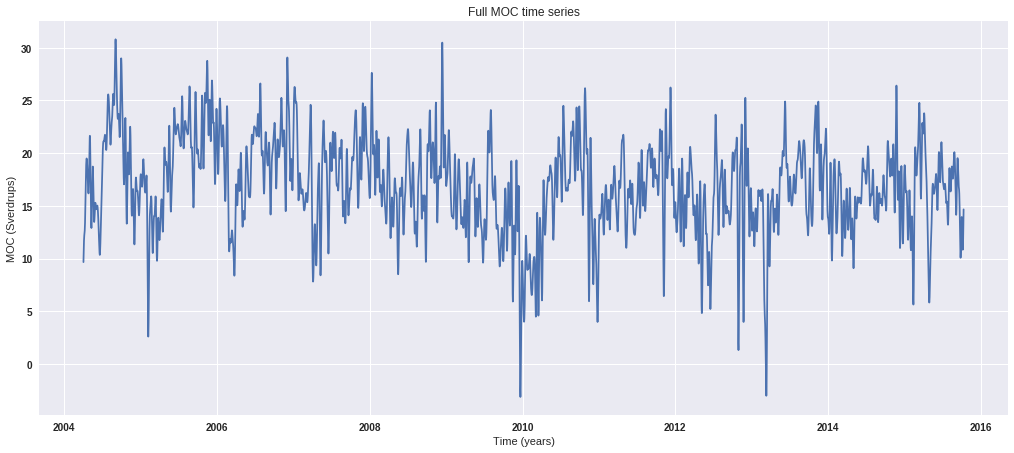

In [34]:
axkwargs = {'xlabel': 'Time (years)', 'ylabel': 'MOC (Sverdrups)', 'title': 'Full MOC time series'}
time_plot(df.index, df.moc, axkwargs = axkwargs)

This plot of the full time series shows that the seasonal cycle accounts for a significant portion of the variability in the time series.  To understand the non-seasonal variability, we remove the seasonal cycle.  We take advantage of time series functionality in xaray to calculate a monthly-mean MOC climatology and then calculate the MOC anomaly with respect to this monthly mean.  We also remove the linear trend.

In [35]:
moc_climatology = ds.moc_mar_hc10.groupby('time.month').mean('time')
moc_anomalies = (ds.moc_mar_hc10.groupby('time.month') - moc_climatology).values

df['moc_anomalies'] = signal.detrend(moc_anomalies, axis = 0)


We plot the new time series for the MOC anomalies.

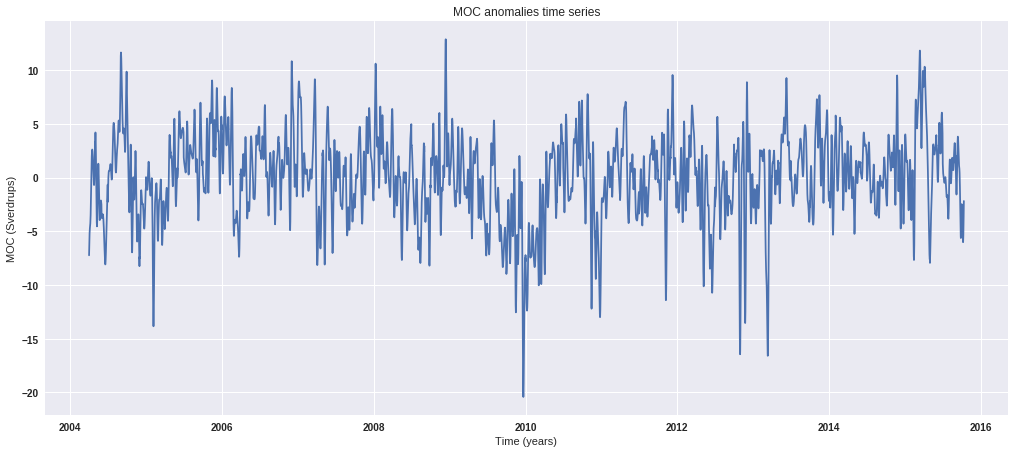

In [36]:
axkwargs = {'xlabel': 'Time (years)', 'ylabel': 'MOC (Sverdrups)', 'title': 'MOC anomalies time series'}
time_plot(df.index ,df.moc_anomalies, axkwargs= axkwargs)

The data now captures the anomalies in the flow and is centered close to 0. We'd guess that the standard deviation is probably around 5 from the plot.

# Bayesian model
We would like to describe the variability in the dataset using a probability distribution function (PDF).  Our guess is that the variability can be described using a Gaussian distribution with mean $\mu$ and some unknown variance $\sigma^{2}$ and to this is our first model for the MOC anomalies:

MOC $ = \sim N(\mu, \sigma^{2})$

In this Gaussian model we need to infer two parameters - the mean $\mu$ and the variance $\sigma^{2}$.  By using Bayesian inference we will estimate PDFs for these parameters and so incorporate the uncertainty in our estimate.
The next step after defining the model above is to set out prior distributions for $\mu$ and $\sigma^{2}$.

By inspecting the plot above, we can set a prior distribution for the mean $\mu$ as:

$\mu = N(0, 3^{2})$

This prior suggests that we expect the mean to be somewhere in the approximate range of -6 to +6. We use a mean of 0 in this distribution because the averaging we performed to remove the seasonal cycle should also remove the time-mean and leave us with an average close to 0.  In practice, the data will drive our final estimate of the mean $\mu$ rather than the details of this prior distribution. 

We set a half-normal prior for the positive-definite variance $\sigma^{2}$ as:

$\sigma^{2} = N^{+}(10^{2})$

By allowing $\sigma^{2}$ to cover a relatively wide range of values we're really just making sure with this prior that any crazy-high values of the variance are ruled out letting the data drive the inference.

When fitting a statistical model, it's a good idea to split your data into a training set and a test set. This allows you to get an idea whether the model developed on the training set will work for out-of-sample data and so reduce [overfitting](https://www.coursera.org/learn/machine-learning/lecture/ACpTQ/the-problem-of-overfitting).
In this case we'll train the model on the data up to 2012 and test it on the period since then.  We'll take advantage of Pandas time series operations to make this split.

In [37]:
moc_anomalies_train = df.loc[df.index < pd.datetime(2013,1,1),'moc_anomalies']
moc_anomalies_test = df.loc[df.index >= pd.datetime(2013,1,1),'moc_anomalies']

print("Days in training set", len(moc_anomalies_train), ", Days in test set", len(moc_anomalies_test))

Days in training set 6392 , Days in test set 2027


# Fitting the Bayesian model
We can now fit the Bayesian model to get probability distribution functions for $\mu$ and $\sigma$. To help with this, we define the following function for fitting the data with a Gaussian likelihood using PyMC3.

In [38]:
def gaussian_fit(data = None, mu_prior = None, sigma_prior = None):
    """Fit the Gaussian model conditioned on the data
    
    data is the 1D training dataset
    mu_prior is a dictionary with the parameters of a Normal distribution e.g. mu_prior = {'mean': 0, 'sd': 10}
    sigma_prior is a dictionary with the parameters of a Half-Normal distribution e.g. sigma_prior = {'sd': 10}
    output: 'trace' is the trace of the model fit, 'map_est' is the estimates of the most likely values 
    """

    with pm.Model() as model: 
        # Specify priors
        mu = pm.Normal('mu', mu = mu_prior['mean'], sd = mu_prior['sd']) #Specify the standard deviation rather than the variance
        sigma = pm.HalfNormal('sigma', sd = sigma_prior['sd'])
        # Specify likelihood and feed in data from 
        Y_obs = pm.Normal('Y_obs', mu = mu, sd = sigma, observed = data)
        trace = pm.sample(draws = 500)
        train_samples = pm.sample_ppc(trace=trace,model=model)
        map_est = pm.find_MAP(model = model)
        waic = pm.waic(trace, n_eff= True)
    return trace, train_samples, map_est, waic


We can now infer the parameters $\mu$ and $\sigma$ using this model.

In [39]:
mu_prior = {'mean': 0, 'sd': 10}
sigma_prior = {'sd': 10}
trace,train_samples, map_est, waic = gaussian_fit(data = moc_anomalies_train, mu_prior = mu_prior, sigma_prior = sigma_prior)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -18,100: 100%|██████████| 200000/200000 [00:20<00:00, 9784.68it/s] 
Finished [100%]: Average ELBO = -18,100
100%|██████████| 500/500 [00:02<00:00, 215.51it/s]


Optimization terminated successfully.
         Current function value: 18094.542011
         Iterations: 11
         Function evaluations: 16
         Gradient evaluations: 16


We can view the output by using PyMC3's built-in traceplot function.

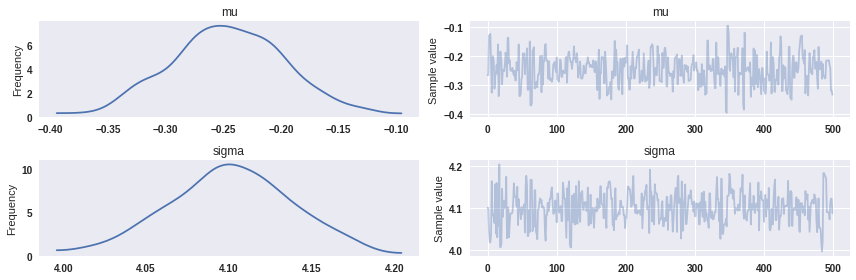

In [41]:
pm.traceplot( trace );

The left-hand panels show the probability distribution functions (PDF) for the parameters $\mu$ and $\sigma$ of the assumed normal distribution for the MOC variability.

The PDF for $\mu$ has low negative values with a low spread.  We expect the mean anomaly to have an average close to 0 Sv over long periods and so this distribution makes sense physically.

Of more interest is the PDF for the standard deviation $\sigma$.  The plot suggests that the variability has a standard deviation has a PDF centered at 4.1 with most of the probability mass in the range from 4.0 to 4.2.

The right hand panels show the 500 individual samples that underlie the PDFs in the left-hand panels.  As all of the samples are in the same range, it does not seem like we have to reject any samples as part of an initial burn-in period.

We can get numeric summaries of this data using PyMC3's summary function on the trace.

In [42]:
pm.summary(trace)


mu:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.246           0.051            0.003            [-0.342, -0.146]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.340         -0.277         -0.246         -0.210         -0.137


sigma:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  4.101            0.037            0.002            [4.038, 4.183]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  4.025          4.076          4.101          4.126          4.174



## Evaluating the model
While we can always fit the model, the crucial step is evaluating the fit in order to understand where the model fails and how we might improve it.  We can first compare the statistical distribution of the observations from the training set with the simulated data. To do so we first define the following plotting function.

In [137]:
def compare_distributions(train_data, simulated_train_data, test_data = None, simulated_test_data = None):
    """Compare the distributions of the actual and simulated data
    
        All inputs are 1d arrays.
        train_data is the actual data for the training period.
        simulated_train_data is the simulated data with the model for the training period.
        Test data can also be added optionally.
        test_data is the actual data for the testing period.
        simulated_test_data is the simulated data with the model for the testing period
    """
    args = locals()
    for key, value in args.items():
        try:
            assert isinstance(value, (np.ndarray,pd.Series,)),'{} should be a numpy array or a pandas Series, but is type {}'.format(key,type(value))
        except: # For the NoneType optional arguments 
            if not value:
                pass
    # Add two subplots if we have test data as well
    if isinstance(test_data, (np.ndarray, pd.Series)):
        ncols = 2
    else:
        ncols = 1
    fig, ax = plt.subplots(nrows =1, ncols = ncols, figsize = (14,7))
    # Make ax into an np.ndarray when there is only one subplot
    if ncols == 1:
        ax = np.array([ ax ])
    sns.kdeplot(train_data, color = 'b',ax = ax[0], label = 'Actual data')
    sns.kdeplot(simulated_train_data,color = 'red',ax = ax[0], label = 'Simulated data')
    ax[0].legend()
    ax[0].set_title('Histograms of actual and simulated values in the train period')
    ax[0].set_xlabel('MOC anomalies (Sverdrups)')

    if ncols == 2:
        sns.kdeplot(test_data, color = 'b',ax = ax[1])
        sns.kdeplot(simulated_test_data,color = 'red',ax = ax[1])
        ax[1].set_title('Histograms of actual and simulated values in the test period')
        ax[1].set_xlabel('MOC anomalies (Sverdrups)')

    plt.show()



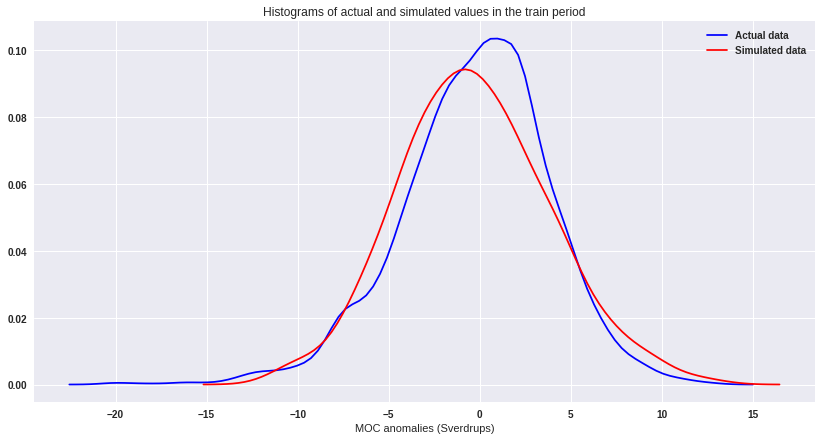

In [138]:
compare_distributions(moc_anomalies_train, train_samples['Y_obs'][:,0])

This comparison shows that the model fit in red has a peak at more negative values. The model predicts larger values in the right tail and does not capture the extremes in the left tail.

The next stage in evaluating the model is to test the fit on out-of-sample data. We can compare the performance of the model between the training data (left) and the out-of-sample test data in the plots below.

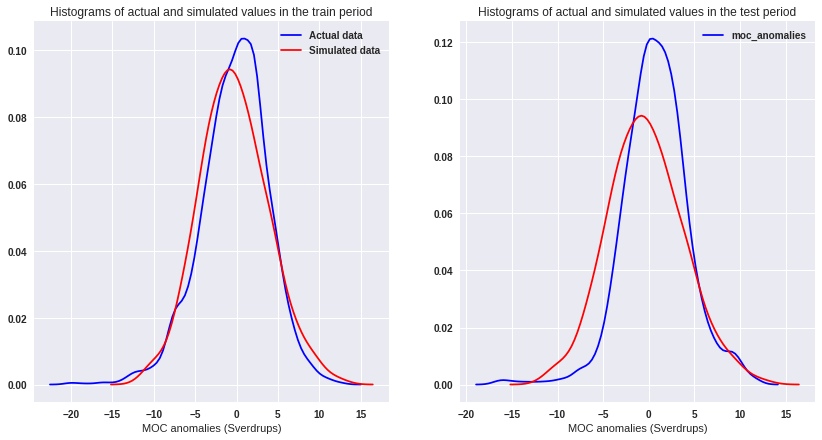

In [139]:
compare_distributions(moc_anomalies_train, train_samples['Y_obs'][:,0],
                     moc_anomalies_test, train_samples['Y_obs'][:,0])

### Gaussian model evaluation

The plots suggest that the model fit does less well in the test period than in the period for which it has been trained - a common phenomenon!  In particular, the tails of the model fit are too large on both sides.  This mismatch tells us that the model may be predicting larger variability than we should expect in practice. We can see that the simulated data is too far to the left in the test period.

The fundamental problem may be that the Gaussian model struggling to fit the large negative values in 2009/2010.  The consequence of this in the test period - when variability was less extreme - is that the simulated data has too much variance on the left-hand side.

The issue here may be that the variability is not Gaussian, and so the Gaussian model is being stretched when we try to fit it to the data.  We may be able to address this by fitting the data to a Student-t distribution instead.

In [118]:
def student_t_fit(train_data = None, degrees_of_freedom_prior = None,
                             mu_prior = None, scale_prior = None):
    """Fit the Student-t model conditioned on the data
    
    train_data is the 1D training dataset
    degrees_of_freedom is a dictionary with the parameters of a Uniform distribution e.g. = {'low': 0, 'high': 100}
    scale_prior is a dictionary with the parameters of a Half-Normal distribution e.g. scale_prior = {'sd': 10}
    output: 'trace' is the trace of the model fit, 'map_est' is the estimates of the most likely values 
    """
    # In order to train the model with train_data and test the model with test_data, we need to create a special type of 
    # 'shared' theano array
    observed = theano.shared(train_data)
    with pm.Model() as model: #Specify priors
        mu = pm.Normal('mu', mu = mu_prior['mean'], sd = mu_prior['sd']) #Specify the standard deviation rather than the variance
        lam = pm.HalfNormal('sigma', sd = scale_prior['sd'])
        df = pm.Uniform('df', degrees_of_freedom_prior['low'], degrees_of_freedom_prior['high'])
        
        Y_obs = pm.StudentT('Y_obs', mu = mu, lam = lam, nu = df, observed = observed)
        
        trace = pm.sample(draws = 1000)
        train_samples = pm.sample_ppc(trace = trace, model = model)
        map_est = pm.find_MAP(model = model)
        waic_train = pm.waic(trace, n_eff= True)

    return trace, train_samples, map_est, waic_train


We can now fit the model where the likelihood is a Student-t distribution.  We use the same priors for the location $\mu$ and scale $\sigma$ parameters.  The key parameter, however, is the degrees of freedom characterising the distribution.  For this we choose a uniform prior over a large range from 0 to 100.

In [119]:
mu_prior = {'mean': 0, 'sd': 10}
scale_prior = {'sd': 10}
degrees_of_freedom_prior = {'low':0, 'high':100}

trace_student,train_samples_student, map_est_student, waic_train_student = student_t_fit(
    train_data = moc_anomalies_train.values,
    degrees_of_freedom_prior = degrees_of_freedom_prior, mu_prior = mu_prior, scale_prior = scale_prior
)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -18,041: 100%|██████████| 200000/200000 [00:43<00:00, 4597.60it/s]
Finished [100%]: Average ELBO = -18,041
100%|██████████| 1000/1000 [00:04<00:00, 232.07it/s]


Optimization terminated successfully.
         Current function value: 18034.629856
         Iterations: 36
         Function evaluations: 62
         Gradient evaluations: 62


As for the Gaussian model, we can inspect the model fit using the *traceplot* function.

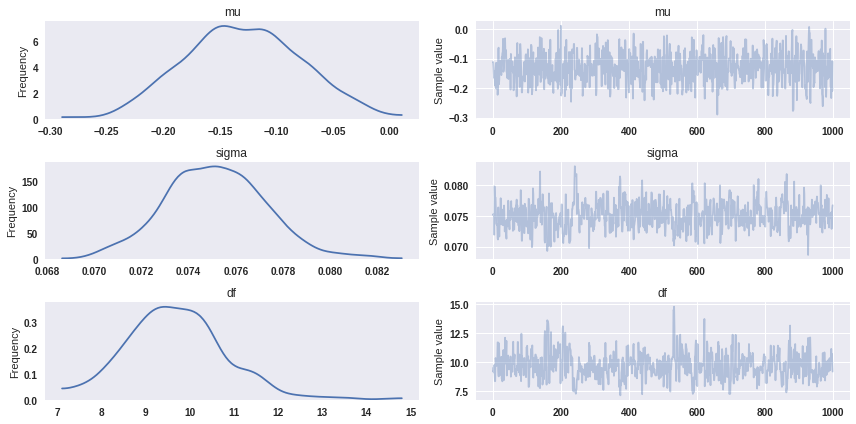

In [120]:
pm.traceplot( trace_student );

### Student-t model evaluation

This shows that there is substantial range for the degrees of freedom from around 7 to 12.

We can also compare this model fit with the actual data in the training and test period:

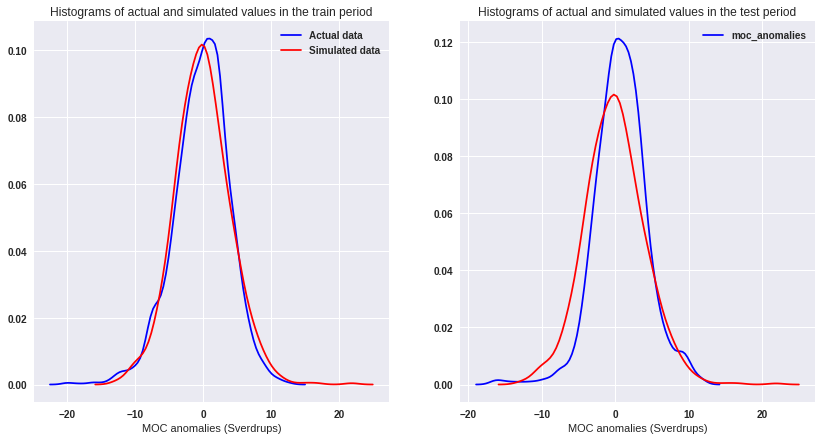

In [158]:
compare_distributions(moc_anomalies_train, train_samples_student['Y_obs'][:,0],
                     moc_anomalies_test, train_samples_student['Y_obs'][:,0])

## Model comparison

There are clearly similar issues with the Student-t fit as with the Gaussian fit.  We can get a better sense of whether the Student-t model has improved by comparing them directly.  First, we define a revised plotting function to compare the models.

In [160]:
def compare_models(train_data, test_data, models, axkwargs = None):
    """Compare the fits of the various models against the data
    
    models is a list of dictionaries
    models[i] = {'train_data':train_data, 'test_data':test_data, 'name':name, 'color':color}
    axkwargs is a list of dictionaries with keyword properties for each axis."""
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16,7))
    sns.kdeplot(train_data, color = 'b',ax = ax[0], label = 'Training data')
    for model in models:
        sns.kdeplot(model['train_data'],color = model['color'],ax = ax[0], label = model['name'])
    ax[0].legend()
    if axkwargs:
        ax[0].set(**axkwargs[0])

    sns.kdeplot(test_data, color = 'b',ax = ax[1], label = 'Test data')
    for model in models:
        sns.kdeplot(model['test_data'],color = model['color'],ax = ax[1], label = model['name'])
    if axkwargs:
        ax[1].set(**axkwargs[1])
    plt.show()

And we can use this to compare the models and data below.

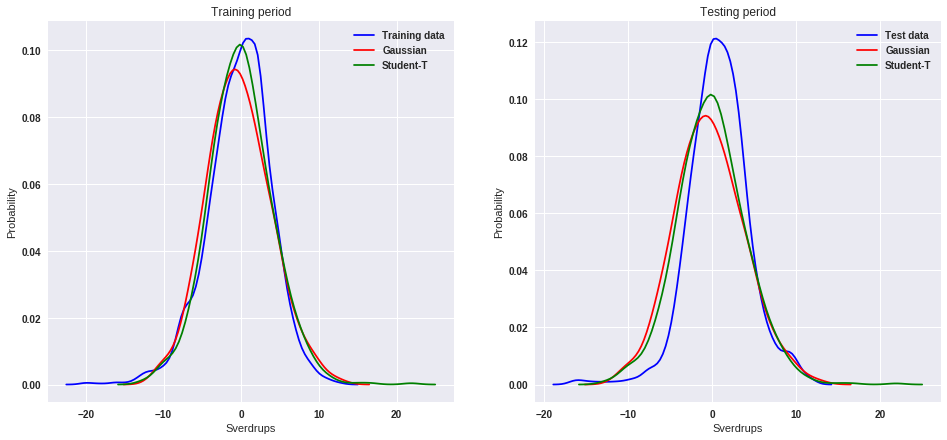

In [161]:
models = [{'train_data':train_samples['Y_obs'][:,0], 'test_data':train_samples['Y_obs'][:,0], 'name':'Gaussian', 'color': 'red' }, 
         {'train_data':train_samples_student['Y_obs'][:,0], 'test_data':train_samples_student['Y_obs'][:,0], 'name':'Student-T', 'color': 'green' }]
axkwargs = [
    {'title' : 'Training period', 'xlabel': 'Sverdrups', 'ylabel': 'Probability'},
    {'title' : 'Testing period', 'xlabel': 'Sverdrups', 'ylabel': 'Probability'}]
compare_models(train_data=moc_anomalies_train, test_data = moc_anomalies_test, 
               models = models, axkwargs = axkwargs)

## Conclusion

This comparison shows that the Student-t fit has improved the fit over the Gaussian model in both the training and test periods.  The presence of the extreme negative values in 2009/2010 will always lead to problems when trying to fit a symmetrical distribution to the data.  

The question then is whether corresponding extreme positive values can occur but the sampling period has not been long enough to observe them, or whether such extreme negative values are indicative that the ocean circulation is non-stationary and undergoing significant shifts in time.

This workbook shows an example of fitting models to a dataset.  The next workbook will show how Bayesian inference can be used to account for uncertainty in time-series forecasting.